In [1]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset
from ts_transform import split_idx_50_50
from pytorchtools import to_torch

In [2]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }




output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "BATTERY"
save_model_file = "model6.pt"
load_model_file = "model6.pt"
lower_trial = 0
upper_trial = 3
learning_rate = 0.0001
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 200
noise_level = 0.0
noise_type = "additive"

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}

assert model_name in ("FCN", "LSTM"), "Model was not correctly specified"
assert dataset_name in ("POLLUTION", "HR", "BATTERY")

window_size, task_size, input_dim = meta_info[dataset_name]
grid = [0., noise_level]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [3]:
save_model_file_ = output_directory+save_model_file
load_model_file_ = output_directory+load_model_file

if is_test == 0:
    test_data = validation_data

train_idx, val_idx, test_idx = split_idx_50_50(test_data.file_idx) if is_test else split_idx_50_50(validation_data.file_idx)
n_domains_in_test = np.max(test_data.file_idx)+1

test_loss_list = []
initial_test_loss_list = []

trial = 0
learning_rate = 0.0001
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file

model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
model2 = nn.Linear(120, 1)

model.cuda()
model2.cuda()

maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
model.load_state_dict(torch.load(save_model_file_))
maml.load_state_dict(torch.load(save_model_file_2))

30
[     0  22605  27382  35100  42811  48043  70648  79698 106020 111577
 137899 146928 152677 178460 183947 189407 197725 206043 231826 239879
 247911 253221 278288 303355 308842 333212 338699 344282 352170 360058
 384428]
0
22605
27382
35100
42811
48043
70648
79698
106020
111577
137899
146928
152677
178460
183947
189407
197725
206043
231826
239879
247911
253221
278288
303355
308842
333212
338699
344282
352170
360058


<All keys matched successfully>

In [4]:
learning_rate = 0.0001
adaptation_steps = 10
n_domains_in_test = np.max(test_data.file_idx)+1
horizon = 0
error_list = []
pred_before = []
pred_after = []
y_list = []
for domain in range(n_domains_in_test):
    x_test = test_data.x
    y_test = test_data.y


    temp_train_data = SimpleDataset(x=np.concatenate([x_test[ np.concatenate([train_idx[domain],val_idx[domain]])][np.newaxis,:], x_test[ test_idx[domain]][np.newaxis,:]]), 
                                                            y =np.concatenate([ y_test[np.concatenate([train_idx[domain],val_idx[domain]])][np.newaxis,:], y_test[test_idx[domain]][np.newaxis,:]]))


    total_tasks_test = len(test_data_ML)
    

    learner = maml.clone()  # Creates a clone of model
    learner.cuda()
    accum_error = 0.0
    accum_std = 0.0
    count = 0.0
    grid = [0., noise_level]

    input_dim = test_data_ML.x.shape[-1]
    window_size = test_data_ML.x.shape[-2]
    output_dim = test_data_ML.y.shape[-1]

    if is_test:
        step = total_tasks_test//100

    else:
        step = 1

    step = 1 if step == 0 else step

    task = 0


    model2 = nn.Linear(120, 1)
    model2.load_state_dict(copy.deepcopy(maml.module.state_dict()))

    model.cuda()
    model2.cuda()
    #model2.cuda()
    #model2.load_state_dict(copy.deepcopy(maml.module.state_dict()))
    #opt2 = optim.Adam(model2.parameters(), lr=learning_rate)
    #learner = maml.clone() 

    x_spt, y_spt = temp_train_data[task]
    x_qry = temp_train_data.x[(task+1)]
    y_qry = temp_train_data.y[(task+1)]
    #x_qry = test_data_ML.x[(task+1)].reshape(-1, window_size, input_dim)
    #y_qry = test_data_ML.y[(task+1)].reshape(-1, output_dim)

    if model_name == "FCN":
        x_qry = np.transpose(x_qry, [0,2,1])
        x_spt = np.transpose(x_spt, [0,2,1])

    x_spt, y_spt = to_torch(x_spt), to_torch(y_spt)
    x_qry = to_torch(x_qry)
    y_qry = to_torch(y_qry)


    epsilon = grid[np.random.randint(0,len(grid))]

    if noise_type == "additive":
        y_spt = y_spt+epsilon
        y_qry = y_qry+epsilon

    else:
        y_spt = y_spt*(1+epsilon)
        y_qry = y_qry*(1+epsilon)

    opt2 = optim.SGD(list(model2.parameters()), lr=learning_rate)
    #learner.module.train()
    size_back = 200
    step_size =  task_size*size_back
    
    temp_pred = []
    for idx in range(0, x_qry.shape[0], step):
        pred = model2(model.encoder(x_qry[idx:idx+step]))
        temp_pred.append(pred.cpu().detach().numpy())
    pred_before.append(np.concatenate(temp_pred))

    #model2.eval()
    for step in range(adaptation_steps):

        print(step)
        #model2.train()
        for idx in range(x_spt.shape[0]-task_size*size_back, x_spt.shape[0], step_size):

            pred = model2(model.encoder(x_spt[idx:idx+step_size]))
            print(pred.shape)
            print(step_size)
            error = mae(pred, y_spt[idx:idx+step_size])
            print(error)
            opt2.zero_grad()
            error.backward()

            #learner.adapt(error)
            opt2.step()

    #model2.eval()
    #learner.module.eval()
    step = x_qry.shape[0]//255
    for idx in range(0, x_qry.shape[0], step):
        pred = model2(model.encoder(x_qry[idx:idx+step]))
        error = mae(pred, y_qry[idx:idx+step])

        accum_error += error.data
        accum_std += error.data**2
        count += 1

    error = accum_error/count
    
    temp_pred = []
    for idx in range(0, x_qry.shape[0], step):
        pred = model2(model.encoder(x_qry[idx:idx+step]))
        temp_pred.append(pred.cpu().detach().numpy())
    pred_after.append(np.concatenate(temp_pred))
    
    y_list.append(y_qry.cpu().numpy())
    error_list.append(float(error.cpu().numpy()))
    print(np.mean(error_list))
    print(error_list)

0
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
1
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
2
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
3
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
4
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
5
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
6
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
7
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
8
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
9
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
0.0016336821718141437
[0.0016336821718141437]
0
torch.Size([2389, 1])
10000
tensor(0.0030, device='cuda:0', grad_fn=<Mea

tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
5
torch.Size([2779, 1])
10000
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
6
torch.Size([2779, 1])
10000
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
7
torch.Size([2779, 1])
10000
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
8
torch.Size([2779, 1])
10000
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
9
torch.Size([2779, 1])
10000
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
0.0033326861707286704
[0.0016336821718141437, 0.004725787788629532, 0.0027422711718827486, 0.002722456818446517, 0.007769040297716856, 0.001625332864932716, 0.0036979629658162594, 0.0020177983678877354, 0.0030598430894315243]
0
torch.Size([10000, 1])
10000
tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
1
torch.Size([10000, 1])
10000
tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
2
torch.Size([10000, 1])
10000
tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
3
torch.Size([1000

tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
6
torch.Size([4159, 1])
10000
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
7
torch.Size([4159, 1])
10000
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
8
torch.Size([4159, 1])
10000
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
9
torch.Size([4159, 1])
10000
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
0.0032144718716153875
[0.0016336821718141437, 0.004725787788629532, 0.0027422711718827486, 0.002722456818446517, 0.007769040297716856, 0.001625332864932716, 0.0036979629658162594, 0.0020177983678877354, 0.0030598430894315243, 0.0018745438428595662, 0.0033415891230106354, 0.004469025880098343, 0.0018908643396571279, 0.0037895627319812775, 0.003506644396111369, 0.002565144095569849]
0
torch.Size([4159, 1])
10000
tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
1
torch.Size([4159, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
2
torch.Size([4159, 1])
10000
tensor(

9
torch.Size([10000, 1])
10000
tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
0.002967505816327916
[0.0016336821718141437, 0.004725787788629532, 0.0027422711718827486, 0.002722456818446517, 0.007769040297716856, 0.001625332864932716, 0.0036979629658162594, 0.0020177983678877354, 0.0030598430894315243, 0.0018745438428595662, 0.0033415891230106354, 0.004469025880098343, 0.0018908643396571279, 0.0037895627319812775, 0.003506644396111369, 0.002565144095569849, 0.0023702685721218586, 0.0016556669725105166, 0.002564354334026575, 0.0022134603932499886, 0.003352212719619274, 0.001697615021839738]
0
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
1
torch.Size([10000, 1])
10000
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
2
torch.Size([10000, 1])
10000
tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
3
torch.Size([10000, 1])
10000
tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
4
torch.Size([10000, 1])
10000
tensor(0.00

tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
4
torch.Size([3944, 1])
10000
tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
5
torch.Size([3944, 1])
10000
tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
6
torch.Size([3944, 1])
10000
tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
7
torch.Size([3944, 1])
10000
tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
8
torch.Size([3944, 1])
10000
tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
9
torch.Size([3944, 1])
10000
tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)
0.003290091341893588
[0.0016336821718141437, 0.004725787788629532, 0.0027422711718827486, 0.002722456818446517, 0.007769040297716856, 0.001625332864932716, 0.0036979629658162594, 0.0020177983678877354, 0.0030598430894315243, 0.0018745438428595662, 0.0033415891230106354, 0.004469025880098343, 0.0018908643396571279, 0.0037895627319812775, 0.003506644396111369, 0.002565144095569849, 0.0023702685721218586, 0.0016556669725

In [10]:
np.mean(error_list)

0.0032433126975471775

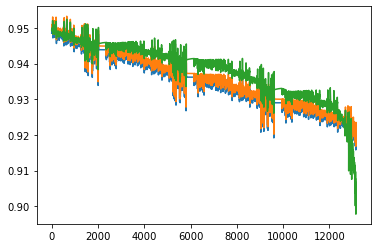

In [28]:
import matplotlib.pyplot as plt

plt.plot(pred_after[7])
plt.plot(pred_before[7])
plt.plot(y_list[7])

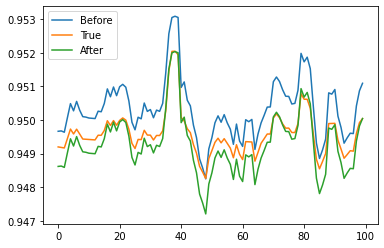

In [27]:
plt.plot(pred_before[7][:100])
plt.plot(y_list[7][:100])
plt.plot(pred_after[7][:100])

plt.legend(["Before", "True", "After"])

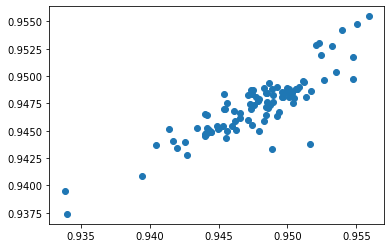

In [20]:
plt.scatter(pred_after[6][:100], y_list[6][:100])

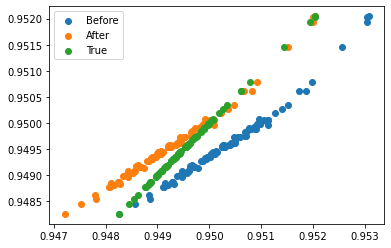

In [26]:
plt.scatter(pred_before[7][:100], y_list[7][:100])
plt.scatter(pred_after[7][:100], y_list[7][:100])
plt.scatter(y_list[7][:100], y_list[7][:100])

plt.legend(["Before", "After", "True"])

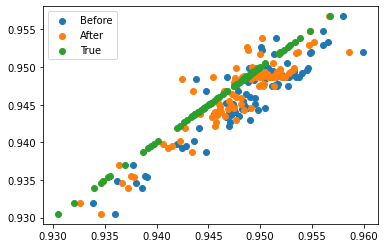

In [39]:
domain = 2
plt.scatter(pred_before[domain][:100], y_list[domain][:100])
plt.scatter(pred_after[domain][:100], y_list[domain][:100])
plt.scatter(y_list[domain][:100], y_list[domain][:100])

plt.legend(["Before", "After", "True"])

In [22]:
plt.scatter(pred_before[2], pred_after[2])

IndexError: list index out of range

In [10]:
for idx in range(0, x_qry.shape[0], step):
    pred = model2(model.encoder(x_qry[idx:idx+step]))
    error = mae(pred, y_qry[idx:idx+step])

    accum_error += error.data
    accum_std += error.data**2
    count += 1

error = accum_error/count

In [8]:
pred_after[0]

tensor([[0.9541],
        [0.9551],
        [0.9558],
        ...,
        [0.9271],
        [0.9271],
        [0.9280]], device='cuda:0', grad_fn=<AddmmBackward>)

In [12]:
np.mean(error_list)

0.0036643020808696746

In [11]:
pred_before[0]

array([[0.9543774 ],
       [0.9553386 ],
       [0.9560443 ],
       ...,
       [0.92741156],
       [0.9273966 ],
       [0.9282807 ]], dtype=float32)